In [61]:
import os
import pandas as pd
import json
import seaborn as sns
from matplotlib import pyplot as plt

## Fetch full dataset from Polaris (optional)

## Load data

In [47]:
df = pd.read_parquet('data/belka_sample.parquet').set_index('id')

print('Dataset columns:', df.columns)
print('Dataset shape:', df.shape)
print('Unique molecules in the dataset:', df['molecule_smiles'].nunique())
print('Unique targets in the dataset:', df['protein_name'].unique())

# We need amino acid sequences for Boltz!
aaseqs = {
    'HSA': "DAHKSEVAHRFKDLGEENFKALVLIAFAQYLQQCPFEDHVKLVNEVTEFAKTCVADESAENCDKSLHTLFGDKLCTVATLRETYGEMADCCAKQEPERNECFLQHKDDNPNLPRLVRPEVDVMCTAFHDNEETFLKKYLYEIARRHPYFYAPELLFFAKRYKAAFTECCQAADKAACLLPKLDELRDEGKASSAKQRLKCASLQKFGERAFKAWAVARLSQRFPKAEFAEVSKLVTDLTKVHTECCHGDLLECADDRADLAKYICENQDSISSKLKECCEKPLLEKSHCIAEVENDEMPADLPSLAADFVESKDVCKNYAEAKDVFLGMFLYEYARRHPDYSVVLLLRLAKTYETTLEKCCAAADPHECYAKVFDEFKPLVEEPQNLIKQNCELFEQLGEYKFQNALLVRYTKKVPQVSTPTLVEVSRNLGKVGSKCCKHPEAKRMPCAEDYLSVVLNQLCVLHEKTPVSDRVTKCCTESLVNRRPCFSALEVDETYVPKEFNAETFTFHADICTLSEKERQIKKQTALVELVKHKPKATKEQLKAVMDDFAAFVEKCCKADDKETCFAEEGKKLVAASQAALGL",
    'sEH': "TLRAAVFDLDGVLALPAVFGVLGRTEEALALPRGLLNDAFQKGGPEGATTRLMKGEITLSQWIPLMEENCRKCSETAKVCLPKNFSIKEIFDKAISARKINRPMLQAALMLRKKGFTTAILTNTWLDDRAERDGLAQLMCELKMHFDFLIESCQVGMVKPEPQIYKFLLDTLKASPSEVVFLDDIGANLKPARDLGMVTILVQDTDTALKELEKVTGIQLLNTPAPLPTSCNPSDMSHGYVTVKPRVRLHFVELGSGPAVCLCHGFPESWYSWRYQIPALAQAGYRVLAMDMKGYGESSAPPEIEEYCMEVLCKEMVTFLDKLGLSQAVFIGHDWGGMLVWYMALFYPERVRAVASLNTPFIPANPNMSPLESIKANPVFDYQLYFQEPGVAEAELEQNLSRTFKSLFRASDESVLSMHKVCEAGGLFVNSPEEPSLSRMVTEEEIQFYVQQFKKSGFRGPLNWYRNMERNWKWACKSLGRKILIPALMVTAEKDFVLVPQMSQHMEDWIPHLKRGHIEDCGHWTQMDKPTEVNQILIKWLDSDARNPPVVSKM",
    'BRD4': "NPPPPETSNPNKPKRQTNQLQYLLRVVLKTLWKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFTNCYIYNKPGDDIVLMAEALEKLFLQKINELPTEETEIMIVQAKGRGRGRKETGTAKPGVSTVPNTTQASTPPQTQTPQPNPPPVQATPHPFPAVTPDLIVQTPVMTVVPPQPLQTPPPVPPQPQPPPAPAPQPVQSHPPIIAATPQPVKTKKGVKRKADTTTPTTIDPIHEPPSLPPEPKTTKLGQRRESSRPVKPPKKDVPDSQQHPAPEKSSKVSEQLKCCSGILKEMFAKKHAAYAWPFYKPVDVEALGLHDYCDIIKHPMDMSTIKSKLEAREYRDAQEFGADVRLMFSNCYKYNPPDHEVVAMARKLQDVFEMRFAKMPDE"
}
df['aaseqs'] = df['protein_name'].map(aaseqs)

Dataset columns: Index(['buildingblock1_smiles', 'buildingblock2_smiles',
       'buildingblock3_smiles', 'molecule_smiles', 'protein_name', 'binds'],
      dtype='object')
Dataset shape: (60000, 6)
Unique molecules in the dataset: 59963
Unique targets in the dataset: ['sEH' 'BRD4' 'HSA']


In [50]:
'''
>{protein_name}|protein|{msa_path}
{aaseq}
>compound|smiles
{smiles}
'''
output_dir = 'boltz-inputs'
os.makedirs(output_dir, exist_ok=True)

# Group by protein and molecule
grouped = df.groupby(['protein_name', 'binds'])

for (protein, binds), group in grouped:
    for idx, row in group.head(100).iterrows():
        fasta_filename = os.path.join(output_dir, f"{protein}_{binds}_{idx}.fasta")
        fasta_content = f">{protein}|protein|./msa/{protein}.csv\n{row['aaseqs']}\n>C|smiles\n{row['molecule_smiles']}\n"
        with open(fasta_filename, 'w') as f:
            f.write(fasta_content)

## Run inference
See inference_runner.py.

## Parse inference results

In [74]:
preds_dir = 'boltz-outputs/boltz_results_boltz-inputs/predictions'
data = []

for folder in os.listdir(preds_dir):
    folder_path = os.path.join(preds_dir, folder)
    if os.path.isdir(folder_path):
        parts = folder.split('_', 2)
        if len(parts) < 3:
            continue
        protein_name, binds, molecule_id = parts
        # Find the confidence JSON file
        json_files = [f for f in os.listdir(folder_path) if f.startswith('confidence') and f.endswith('.json')]
        if not json_files:
            continue
        json_path = os.path.join(folder_path, json_files[0])  # Assuming one per folder
        with open(json_path, 'r') as f:
            json_data = json.load(f)
        # Add parsed folder info to json data
        json_data['protein_name'] = protein_name
        json_data['binds'] = binds
        json_data['molecule_id'] = molecule_id
        data.append(json_data)

# Create dataframe
df_confidences = pd.DataFrame(data)

print(df_confidences.head())

   confidence_score       ptm      iptm  ligand_iptm  protein_iptm  \
0          0.750034  0.813500  0.275654     0.275654           0.0   
1          0.790789  0.825988  0.440335     0.440335           0.0   
2          0.856165  0.792284  0.643168     0.643168           0.0   
3          0.896591  0.763341  0.794135     0.794135           0.0   
4          0.812996  0.763807  0.483695     0.483695           0.0   

   complex_plddt  complex_iplddt  complex_pde  complex_ipde  \
0       0.868628        0.393382     1.540370     11.399547   
1       0.878403        0.477360     1.327137      8.698422   
2       0.909414        0.601152     0.777504      4.689939   
3       0.922204        0.759908     0.638356      3.197254   
4       0.895321        0.520389     1.438346      9.995440   

                                          chains_ptm  \
0  {'0': 0.8527267575263977, '1': 0.7625957131385...   
1  {'0': 0.8551216721534729, '1': 0.7425139546394...   
2  {'0': 0.8042490482330322, '1'

## Plot confidence vs. binds

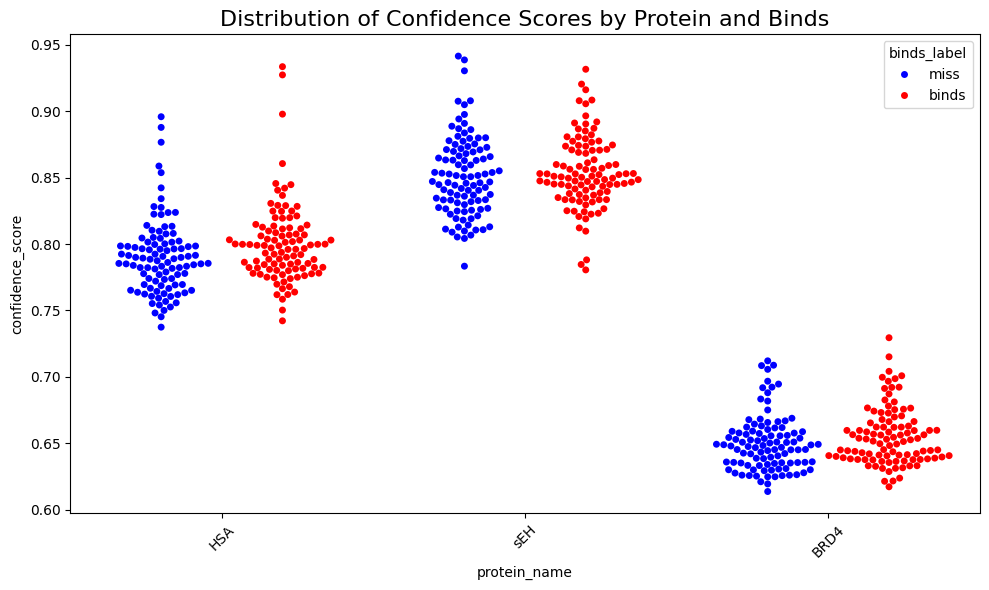

In [80]:
# Map 'binds' to categorical labels
df_confidences['binds_label'] = df_confidences['binds'].apply(lambda x: 'binds' if x == '1' else 'miss')
metric = 'ligand_iptm'

# Create the swarmplot
plt.figure(figsize=(10, 6))
sns.swarmplot(
    data=df_confidences,
    x='protein_name',
    y='confidence_score',
    hue='binds_label',
    dodge=True,  # Add this parameter to separate the clusters
    palette={'binds': 'red', 'miss': 'blue'}
)

plt.title('Distribution of Confidence Scores by Protein and Binds', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [84]:
import numpy as np
from math import erf, sqrt

def norm_cdf(x):
    return 0.5 * (1 + erf(x / sqrt(2)))

def mann_whitney_u(x, y):
    nx, ny = len(x), len(y)
    
    combined = np.concatenate([x, y])
    ranks = np.zeros(len(combined))
    
    sorted_indices = np.argsort(combined)
    rank = 1
    i = 0
    while i < len(sorted_indices):
        j = i
        while j < len(sorted_indices)-1 and combined[sorted_indices[j]] == combined[sorted_indices[j+1]]:
            j += 1
        avg_rank = rank + (j - i) / 2
        for k in range(i, j+1):
            ranks[sorted_indices[k]] = avg_rank
        rank = j + 2
        i = j + 1

    rank_sum_x = np.sum(ranks[:nx])
    u1 = rank_sum_x - (nx * (nx + 1)) / 2
    u2 = nx * ny - u1
    u = u1  # Use u1 for one-sided test (x > y)
    
    mu_u = (nx * ny) / 2
    sigma_u = np.sqrt((nx * ny * (nx + ny + 1)) / 12)
    z = (u - mu_u) / sigma_u
    
    # One-sided p-value
    p_value = 1 - norm_cdf(z)
    
    return u, p_value

results = []

for protein in df_confidences['protein_name'].unique():
    binds = df_confidences[
        (df_confidences['protein_name'] == protein) & 
        (df_confidences['binds_label'] == 'binds')
    ][metric]
    misses = df_confidences[
        (df_confidences['protein_name'] == protein) & 
        (df_confidences['binds_label'] == 'miss')
    ][metric]
    
    if len(binds) > 0 and len(misses) > 0:
        stat, p = mann_whitney_u(binds, misses)
        results.append({
            'protein': protein,
            'statistic': stat,
            'p-value': p
        })
    else:
        results.append({
            'protein': protein,
            'statistic': None,
            'p-value': None
        })

df_pvalues = pd.DataFrame(results)
print(df_pvalues)


  protein  statistic   p-value
0     HSA     6146.0  0.002554
1     sEH     5537.0  0.094743
2    BRD4     5698.0  0.044052
